# Description
This challenge was designed specifically for the AI Tunisia Hack 2019, which takes place from 20 to 22 September. Welcome to the AI Tunisia Hack participants!

After AI Hack Tunisia, this competition will be re-opened as a Knowledge Challenge to allow others in the Zindi community to learn and test their skills.

Flight delays not only irritate air passengers and disrupt their schedules but also cause :

- a decrease in efficiency
- an increase in capital costs, reallocation of flight crews and aircraft
- an additional crew expenses
- As a result, on an aggregate basis, an airline's record of flight delays may have a negative impact on passenger demand.

`This competition aims to predict the estimated duration of flight delays per flight`

This solution proposes to build a flight delay predictive model using Machine Learning techniques. The accurate prediction of flight delays will help all players in the air travel ecosystem to set up effective action plans to reduce the impact of the delays and avoid loss of time, capital and resources.

Variable definitions

- ID
- DATOP - Date of flight
- FLTID - Flight number
- DEPSTN - Departure point
- ARRSTN - Arrival point
- STD - Scheduled Time departure
- STA - Scheduled Time arrival
- STATUS - Flight status
- AC - Aircraft Code

source: [https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/](https://zindi.africa/competitions/ai-tunisia-hack-5-predictive-analytics-challenge-2/)

Additionally, we use a dataset giving information about the airports.
[https://pypi.org/project/airportsdata/](https://pypi.org/project/airportsdata/) 

In [68]:
# import the necessary libraries we need for your analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, accuracy_score, mean_squared_error

RSEED =  42

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Train.csv',parse_dates=['DATOP','STD']) # 'STA' is not recognized due to . instead of :
df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02.00.00,SCH,TU 32AIML,0.0
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09.00.00,SCH,UG AT7AT7,0.0
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0


In [3]:
# So, what size does the dataset has?
print("\n", f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.", "\n")

# Now, let us take a view to the columns and their type:
df.info()


 The dataset has 107833 rows and 10 columns. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   ID      107833 non-null  object        
 1   DATOP   107833 non-null  datetime64[ns]
 2   FLTID   107833 non-null  object        
 3   DEPSTN  107833 non-null  object        
 4   ARRSTN  107833 non-null  object        
 5   STD     107833 non-null  datetime64[ns]
 6   STA     107833 non-null  object        
 7   STATUS  107833 non-null  object        
 8   AC      107833 non-null  object        
 9   target  107833 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 8.2+ MB


In [4]:
# How many unique entries do the features have?
df.nunique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [5]:
# Checking for missing values
missing = pd.DataFrame(df.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/df.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


In [6]:
# Check for duplicated values
df.duplicated().unique()

array([False])

So, all of our feature are non-numeric, but some feature have date-specific information. To proceed, we create a copy of the dataframe and apply changes to the columns.

In [7]:
# Replace . with : and convert it to datetime object
df['STA'] = df['STA'].apply(lambda x: x.replace('.',':'))
df['STA'] = pd.to_datetime(df['STA'])

# alternative:
# df['STA'].replace('\.',':', regex=True,inplace=True)

In [8]:
# Create years, month etc.
df['hour'] = df.STD.dt.hour
df['month'] = df.DATOP.dt.month
df['year'] = df.DATOP.dt.year
df['day_of_week'] = df.DATOP.dt.day_of_week # The day of the week with Monday=0, Sunday=6
df['scheduled_time_duration'] = (df['STA']-df['STD']).dt.total_seconds()/60 # planed flight duration

In [9]:
# Remove ID and STATUS as they are not useful
df.drop(['ID','STATUS'], axis=1, inplace=True)

In [10]:
df.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration
0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0
1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0
2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0
3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0
4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0


Lets get some first visual impressions about the dataset - now as we have numeric features.

#### Import airport data to convert airport iata labels to countries

In [12]:
df_air = pd.read_csv('data/airports.csv')

In [13]:
df_air

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,00AK,NaN,Lowell Field,Anchor Point,Alaska,US,450,59.949200,-151.695999,America/Anchorage
1,00AL,NaN,Epps Airpark,Harvest,Alabama,US,820,34.864799,-86.770302,America/Chicago
2,00AZ,NaN,Cordes Airport,Cordes,Arizona,US,3810,34.305599,-112.165001,America/Phoenix
3,00CA,NaN,Goldstone /Gts/ Airport,Barstow,California,US,3038,35.350498,-116.888000,America/Los_Angeles
4,00CO,NaN,Cass Field,Briggsdale,Colorado,US,4830,40.622200,-104.344002,America/Denver
...,...,...,...,...,...,...,...,...,...,...
28878,ZYTN,TNH,Tonghua Sanyuanpu Airport,Tonghua,Jilin,CN,1200,42.253889,125.703333,Asia/Shanghai
28879,ZYTX,SHE,Taoxian Airport,Shenyang,Liaoning,CN,198,41.639801,123.483002,Asia/Shanghai
28880,ZYXC,XEN,Xingcheng Air Base,NaN,Liaoning,CN,30,40.580299,120.697998,Asia/Shanghai
28881,ZYYJ,YNJ,Yanji Chaoyangchuan Airport,Yanji,Jilin,CN,624,42.882801,129.451004,Asia/Shanghai


In [14]:
# Replace airport iata label with country label

# 1) Arrival point
dict_arr = {}
for iata1 in df['ARRSTN'].unique():
    mask1 = df_air['iata'] == iata1
    country1 = df_air['country'][mask1]
    dict_arr[iata1] = country1.to_string(index=False)

# 2) Departure point
dict_dep = {}
for iata2 in df['DEPSTN'].unique():
    mask2 = df_air['iata'] == iata2
    country2 = df_air['country'][mask2]
    dict_dep[iata2] = country2.to_string(index=False)

# Replace columns
df['ARRSTN'] = df['ARRSTN'].replace(dict_arr)
df['DEPSTN'] = df['DEPSTN'].replace(dict_dep)
    

In [ ]:
df.head()

In [15]:
df['DEPSTN'].unique()	



array(['MA', 'IT', 'TN', 'FR', 'TR', 'BE', 'CI', 'NL', 'DE', 'ES', 'SA',
       'DZ', 'PT', 'BF', 'GB', 'LB', 'MR', 'CH', 'Series([], )', 'EG',
       'RS', 'AT', 'ML', 'SN', 'RW', 'MT', 'CZ', 'SI', 'RU', 'HU', 'SE',
       'DK', 'CA', 'NE', 'DJ', 'IQ', 'TG', 'CD', 'SD', 'GA', 'LT', 'GN',
       'SK', 'JO', 'RO', 'UA', 'GR', 'QA', 'BJ', 'LU', 'IS', 'EE', 'AO',
       'PL', 'BA'], dtype=object)

In [16]:
df['ARRSTN'].unique()	

array(['TN', 'TR', 'FR', 'DZ', 'ES', 'IT', 'SA', 'DE', 'BE', 'MA', 'RS',
       'BF', 'CH', 'LB', 'CI', 'AT', 'MT', 'PT', 'GB', 'EG', 'NL', 'SN',
       'Series([], )', 'SI', 'MR', 'ML', 'CA', 'CZ', 'DK', 'SE', 'DJ',
       'HU', 'RW', 'NE', 'RU', 'IQ', 'SD', 'TG', 'CD', 'GA', 'SK', 'GN',
       'JO', 'RO', 'LT', 'GR', 'BJ', 'UA', 'LU', 'QA', 'AO', 'BA'],
      dtype=object)

We see, for both arrival and departure destinations there are values 'Series([], )'. So, we got airports (iata labels) which are not in the airports.csv dataset. To continue, we will estimated the amount and delete them if they are not predominant in our dataframe.

In [ ]:
# How often do they occur?
df['ARRSTN'].value_counts()

In [ ]:
# How often do they occur?
df['DEPSTN'].value_counts()

In [17]:
# Remove rows where 'ARRSTN' or 'DEPSTN' is 'Series([], )'
df = df.drop(df[(df.ARRSTN == 'Series([], )') | (df.DEPSTN == 'Series([], )')].index)
df.reset_index(drop=True, inplace=True)

#### Feature Encoding

For now, we want to create additional numeric features by performing label encoding. 

In [18]:
# 1) encode departure countries
le1 = LabelEncoder()
le1.fit(df['DEPSTN'])
le1.transform(df['DEPSTN'])
df['DEPSTN'] = le1.transform(df['DEPSTN'])

# 2) encode arrival countries
le2 = LabelEncoder()
le2.fit(df['ARRSTN'])
le2.transform(df['ARRSTN'])
df['ARRSTN'] = le2.transform(df['ARRSTN'])

In [19]:
df

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration
0,2016-01-03,TU 0712,31,48,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0
1,2016-01-13,TU 0757,26,48,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0
2,2016-01-16,TU 0214,51,49,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0
3,2016-01-17,TU 0480,51,17,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0
4,2016-01-17,TU 0338,51,14,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05,WKL 0000,51,48,2018-07-05 23:00:00,2018-07-06 02:00:00,TU 32AIML,0.0,23,7,2018,3,180.0
107168,2018-01-13,UG 0003,51,48,2018-01-13 08:00:00,2018-01-13 09:00:00,UG AT7AT7,0.0,8,1,2018,5,60.0
107169,2018-11-07,SGT 0000,51,48,2018-11-07 05:00:00,2018-11-07 12:50:00,TU 736IOK,0.0,5,11,2018,2,470.0
107170,2018-01-23,UG 0010,51,48,2018-01-23 18:00:00,2018-01-23 18:45:00,TU CR9ISA,0.0,18,1,2018,1,45.0


Now, we can create a correlation heatmap to estimate the correlation between the features and the target.

<AxesSubplot:>

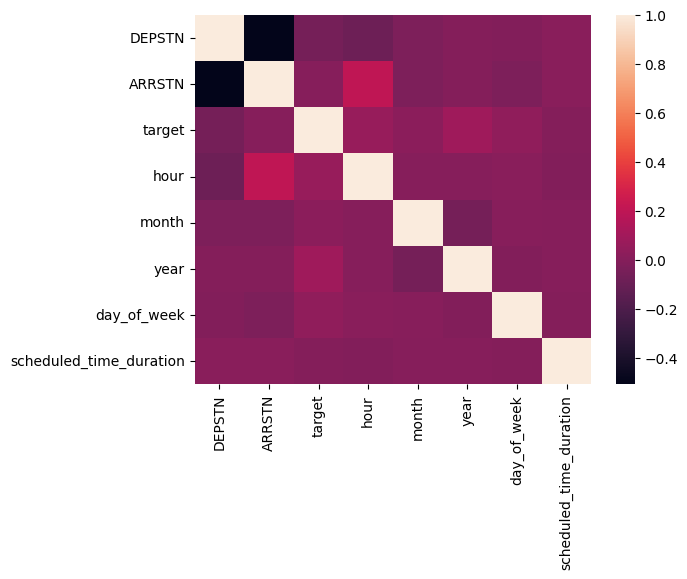

In [20]:
sns.heatmap(df.corr())

### Analysis of flight delayed over the years from 2016-2018 and their relation with seasons

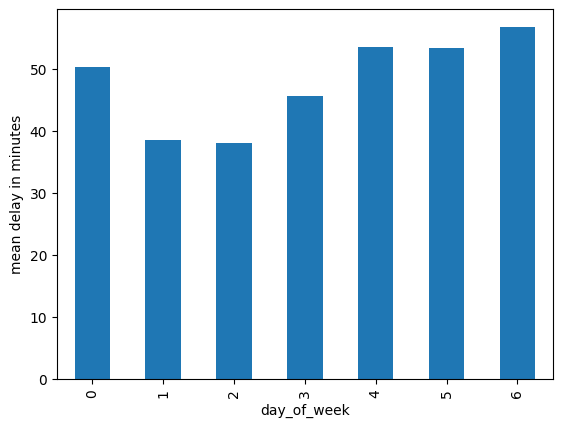

In [26]:
plt.figure()
df.groupby('day_of_week')['target'].mean().plot(kind='bar')
plt.ylabel('mean delay in minutes')
plt.show();

In [ ]:
#Convert target column into categorical to get better idea

# one way to do is
# df['dummy'] =  (df['target']==0.0).astype(int)
# df['dummy'] =  np.where(df['target']==0.0, 0, 1)

In [21]:
#Alternative way of doing the same
def outcome(time_delay):
  if time_delay > 0:
    return '1'
  elif time_delay == 0:
    return '0'
  else:
    return 'NaN'

df['outcome'] = df.target.apply(lambda x: outcome(x))

In [ ]:
df

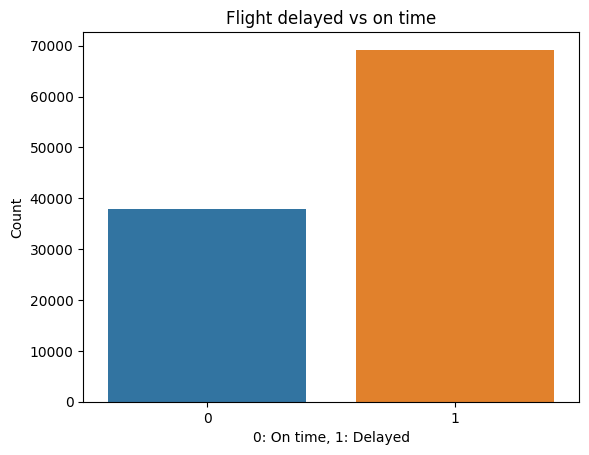

In [23]:
flight_no = df.groupby("outcome").size()
flight_plt = sns.barplot(flight_no.index, flight_no.values)
flight_plt.set(xlabel="0: On time, 1: Delayed", ylabel="Count", title="Flight delayed vs on time")
plt.show()

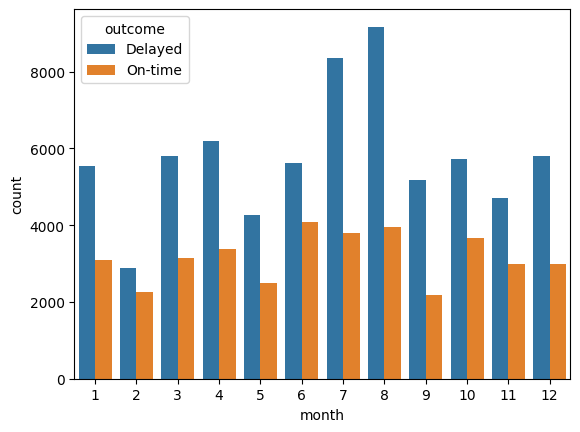

In [24]:
#plot of months with the delay in flghts, where 1 displayed flight delay and 0 when the flight in on time
sns.countplot(df['month'], hue=df['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time']);

In [25]:
#converting months into seasons
df.loc[(df['month'] >= 3) & (df['month'] < 6), 'season'] = "spring"
df.loc[(df['month'] >= 6) & (df['month'] < 9), 'season'] = "summer"
df.loc[(df['month'] >= 9) & (df['month'] < 12), 'season'] = "autumn"
df.loc[(df['month'] < 3) | (df['month'] == 12), 'season'] = "winter"

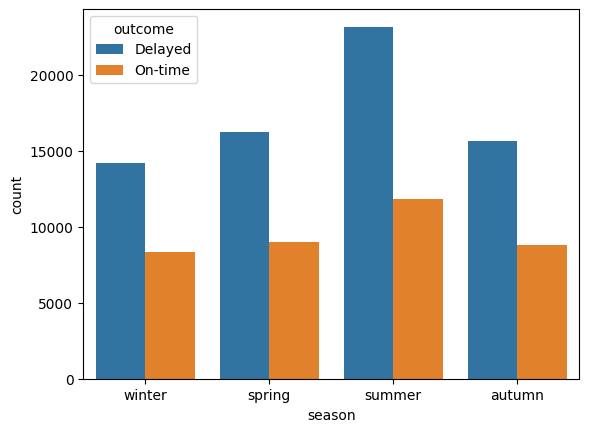

In [27]:
sns.countplot(df['season'], hue=df['outcome'])
plt.legend(title='outcome', loc='upper left', labels=['Delayed', 'On-time']);

In [28]:
df.head()

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,AC,target,hour,month,year,day_of_week,scheduled_time_duration,outcome,season
0,2016-01-03,TU 0712,31,48,2016-01-03 10:30:00,2016-01-03 12:55:00,TU 32AIMN,260.0,10,1,2016,6,145.0,1,winter
1,2016-01-13,TU 0757,26,48,2016-01-13 15:05:00,2016-01-13 16:55:00,TU 31BIMO,20.0,15,1,2016,2,110.0,1,winter
2,2016-01-16,TU 0214,51,49,2016-01-16 04:10:00,2016-01-16 06:45:00,TU 32AIMN,0.0,4,1,2016,5,155.0,0,winter
3,2016-01-17,TU 0480,51,17,2016-01-17 14:10:00,2016-01-17 17:00:00,TU 736IOK,0.0,14,1,2016,6,170.0,0,winter
4,2016-01-17,TU 0338,51,14,2016-01-17 14:30:00,2016-01-17 15:50:00,TU 320IMU,22.0,14,1,2016,6,80.0,1,winter


In [44]:
dep_arr = df[['DEPSTN', 'ARRSTN']].groupby(['DEPSTN', 'ARRSTN']).size()
dep = dep_arr.unstack().unstack()
dep

ARRSTN  DEPSTN
0       0         NaN
        1         NaN
        2         NaN
        3         NaN
        4         NaN
                 ... 
50      49        NaN
        50        NaN
        51        6.0
        52        NaN
        53        NaN
Length: 2754, dtype: float64

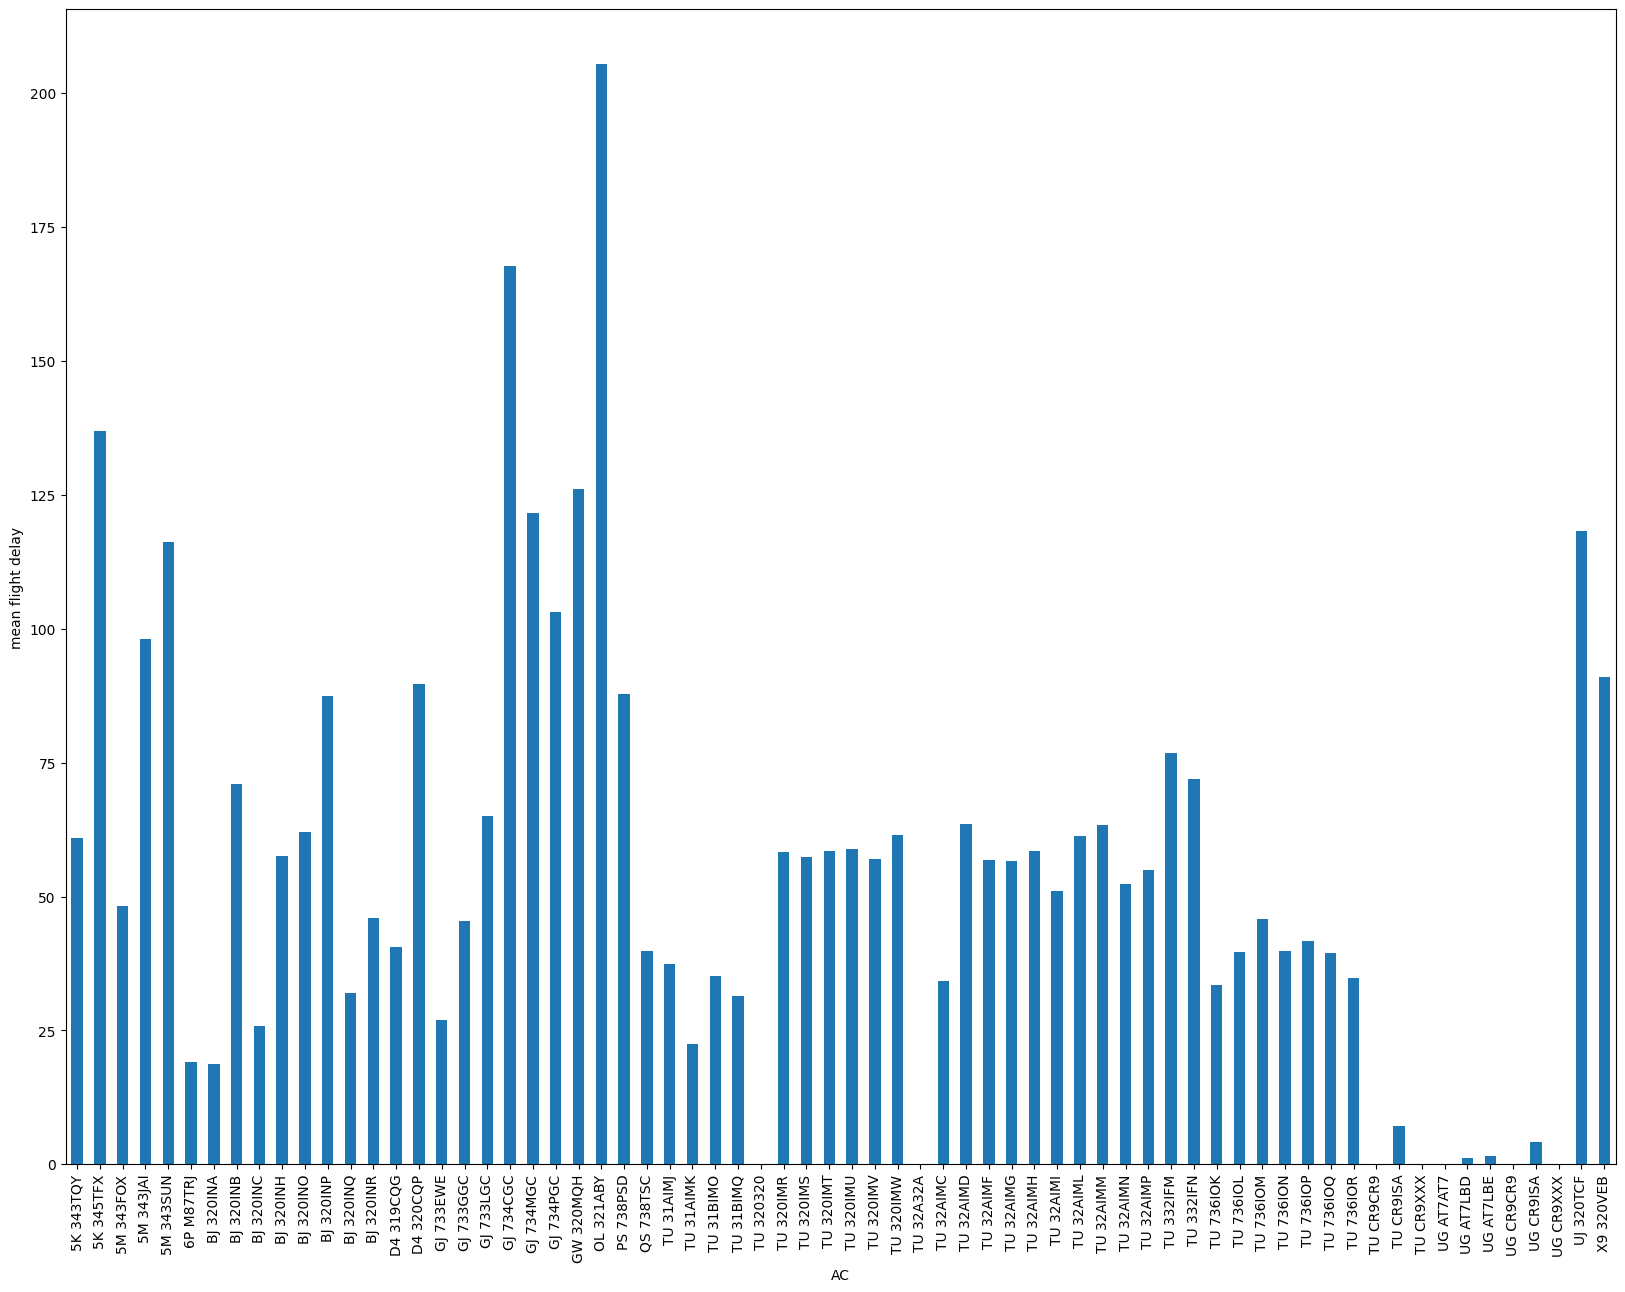

In [35]:
plt.figure(figsize=(20,15))
df.groupby('AC')['target'].mean().plot(kind='bar')
plt.ylabel('mean flight delay')
plt.show();

In [51]:
df1 = df.copy()

In [53]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
df1_raw = df1.copy()
features = pd.get_dummies(df1_raw, columns = ['AC'], drop_first=True)
features

,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,target,hour,month,year,...,AC_TU CR9ISA,AC_TU CR9XXX,AC_UG AT7AT7,AC_UG AT7LBD,AC_UG AT7LBE,AC_UG CR9CR9,AC_UG CR9ISA,AC_UG CR9XXX,AC_UJ 320TCF,AC_X9 320VEB
0,2016-01-03,TU 0712,31,48,2016-01-03 10:30:00,2016-01-03 12:55:00,260.0,10,1,2016,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-13,TU 0757,26,48,2016-01-13 15:05:00,2016-01-13 16:55:00,20.0,15,1,2016,...,0,0,0,0,0,0,0,0,0,0
2,2016-01-16,TU 0214,51,49,2016-01-16 04:10:00,2016-01-16 06:45:00,0.0,4,1,2016,...,0,0,0,0,0,0,0,0,0,0
3,2016-01-17,TU 0480,51,17,2016-01-17 14:10:00,2016-01-17 17:00:00,0.0,14,1,2016,...,0,0,0,0,0,0,0,0,0,0
4,2016-01-17,TU 0338,51,14,2016-01-17 14:30:00,2016-01-17 15:50:00,22.0,14,1,2016,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107167,2018-07-05,WKL 0000,51,48,2018-07-05 23:00:00,2018-07-06 02:00:00,0.0,23,7,2018,...,0,0,0,0,0,0,0,0,0,0
107168,2018-01-13,UG 0003,51,48,2018-01-13 08:00:00,2018-01-13 09:00:00,0.0,8,1,2018,...,0,0,1,0,0,0,0,0,0,0
107169,2018-11-07,SGT 0000,51,48,2018-11-07 05:00:00,2018-11-07 12:50:00,0.0,5,11,2018,...,0,0,0,0,0,0,0,0,0,0
107170,2018-01-23,UG 0010,51,48,2018-01-23 18:00:00,2018-01-23 18:45:00,0.0,18,1,2018,...,1,0,0,0,0,0,0,0,0,0


In [55]:
features.columns

Index(['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'target', 'hour',
       'month', 'year', 'day_of_week', 'scheduled_time_duration', 'outcome',
       'season', 'AC_5K 345TFX', 'AC_5M 343FOX', 'AC_5M 343JAI',
       'AC_5M 343SUN', 'AC_6P M87TRJ', 'AC_BJ 320INA', 'AC_BJ 320INB',
       'AC_BJ 320INC', 'AC_BJ 320INH', 'AC_BJ 320INO', 'AC_BJ 320INP',
       'AC_BJ 320INQ', 'AC_BJ 320INR', 'AC_D4 319CQG', 'AC_D4 320CQP',
       'AC_GJ 733EWE', 'AC_GJ 733GGC', 'AC_GJ 733LGC', 'AC_GJ 734CGC',
       'AC_GJ 734MGC', 'AC_GJ 734PGC', 'AC_GW 320MQH', 'AC_OL 321ABY',
       'AC_PS 738PSD', 'AC_QS 738TSC', 'AC_TU 31AIMJ', 'AC_TU 31AIMK',
       'AC_TU 31BIMO', 'AC_TU 31BIMQ', 'AC_TU 320320', 'AC_TU 320IMR',
       'AC_TU 320IMS', 'AC_TU 320IMT', 'AC_TU 320IMU', 'AC_TU 320IMV',
       'AC_TU 320IMW', 'AC_TU 32A32A', 'AC_TU 32AIMC', 'AC_TU 32AIMD',
       'AC_TU 32AIMF', 'AC_TU 32AIMG', 'AC_TU 32AIMH', 'AC_TU 32AIMI',
       'AC_TU 32AIML', 'AC_TU 32AIMM', 'AC_TU 32AIMN', 'AC_TU 32AIMP',


In [56]:
features.drop(['DATOP','FLTID','STD','STA','outcome','season',], axis=1, inplace=True)

In [57]:
features.head()

,DEPSTN,ARRSTN,target,hour,month,year,day_of_week,scheduled_time_duration,AC_5K 345TFX,AC_5M 343FOX,...,AC_TU CR9ISA,AC_TU CR9XXX,AC_UG AT7AT7,AC_UG AT7LBD,AC_UG AT7LBE,AC_UG CR9CR9,AC_UG CR9ISA,AC_UG CR9XXX,AC_UJ 320TCF,AC_X9 320VEB
0,31,48,260.0,10,1,2016,6,145.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26,48,20.0,15,1,2016,2,110.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,51,49,0.0,4,1,2016,5,155.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,51,17,0.0,14,1,2016,6,170.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,51,14,22.0,14,1,2016,6,80.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
target = np.array(features.pop("target"))

# Base Model

In [60]:
# Split the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RSEED)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 85737 samples.
Testing set has 21435 samples.


In [61]:
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred = lin_reg.predict(X_test)

In [65]:
# Intercept and slope/coefficient can be accessed via .intercept_ and .coef_
intercept = lin_reg.intercept_
slope = lin_reg.coef_
print("Model intercept:", intercept)
print("Coefficient for feature weight:", slope)

Model intercept: -23491.173163208558
Coefficient for feature weight: [-2.77664499e-01 -9.02303217e-02  1.43859877e+00  6.08377824e-01
  1.16706073e+01  2.02011158e+00 -1.19056787e-04  8.52398450e+01
 -2.26087290e+01  4.72884693e+01  7.63348531e+01 -4.49530062e+01
 -4.29682344e+01 -3.53829349e+01 -4.24782820e+01  3.77547541e+01
 -5.12498479e+00  3.16597094e+01 -3.28921087e+01 -1.90365131e+01
 -2.25618698e+01  1.98779179e+01 -4.70919357e+01 -2.86016707e+01
 -1.17954911e+01  6.59854020e+01  3.63730201e+01  3.72023471e+01
  7.10431271e+01  1.04730201e+02  2.47135997e+01 -2.07891280e+01
 -1.89336538e+01 -2.82745080e+01 -3.03759154e+01 -3.36761780e+01
 -6.03919763e+01 -5.23427482e+00 -3.89480923e+00 -4.06915237e+00
 -1.99633103e+00 -6.30286783e+00 -1.09467023e+00 -5.27733959e+01
 -1.69731722e+01 -2.19863122e+00 -5.87457009e+00 -6.85187971e+00
 -6.41242795e+00 -1.02911775e+01 -1.32212868e+00  1.30869713e+00
 -1.20148060e+01 -7.52802477e+00  1.40564958e+01  1.01369909e+01
 -2.87527322e+01 -2.4

In [71]:
# Calcualte the R-squared for our model
print("R-squared:", r2_score(y_test, y_pred).round(3))
print("RMSE-squared:", mean_squared_error(y_test, y_pred, squared=False).round(3))

R-squared: 0.035
RMSE-squared: 111.642


In [81]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sys
from io import StringIO

In [74]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [75]:
# Instantiate our model 
lin_reg_sc = LinearRegression()

lin_reg_sc.fit(X_train_sc, y_train)
y_pred_sc = lin_reg_sc.predict(X_test_sc)

In [76]:
print("R-squared:", r2_score(y_test, y_pred_sc).round(3))
print("RMSE-squared:", mean_squared_error(y_test, y_pred_sc, squared=False).round(3))

R-squared: 0.035
RMSE-squared: 111.642


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 902 out of 902 | elapsed:   38.6s finished


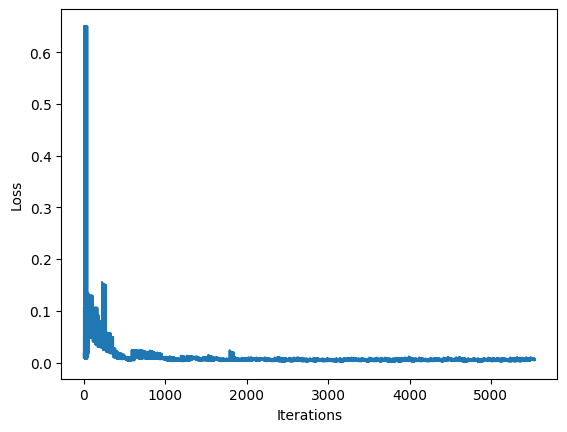

In [82]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()

# You can look up the documentation and play with the hyperparameters
clf = SGDClassifier(loss='log', penalty="l1", alpha= 0.1, verbose=1, n_jobs=-1, random_state=10)
clf.fit(X_train_sc, y_train)

# Plotting the loss function
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [77]:
scaler_MM = MinMaxScaler()

X_train_mm = scaler_MM.fit_transform(X_train)
X_test_mm = scaler_MM.transform(X_test)

In [78]:
lin_reg_mm = LinearRegression()

lin_reg_mm.fit(X_train_mm, y_train)
y_pred_mm = lin_reg_mm.predict(X_test_mm)

In [79]:
print("R-squared-MM:", r2_score(y_test, y_pred_sc).round(3))
print("RMSE-squared-MM:", mean_squared_error(y_test, y_pred_sc, squared=False).round(3))

R-squared-MM: 0.035
RMSE-squared-MM: 111.642
